In [104]:
%autosave 15
%matplotlib inline

import numpy as np
import scipy as sp
import pandas as pd
import math
import random

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from IPython.display import display, HTML

Autosaving every 15 seconds


In [203]:
ndata = []
nactualPrice = dict()
ff_areas = []
ff_rooms = []

def getData():
    fin = open('prices.txt', 'r')
    lines = fin.readlines()
    fin.close()
    
    actualPrice = dict()
    data = list()
    
    areas = []
    rooms = []
    for area, room, price in [map(int, x.split(',')) for x in lines[1:]]:
        data.append((area, room))
        actualPrice[(area, room)] = price
        areas.append(area)
        rooms.append(room)
        ff_areas.append(area)
        ff_rooms.append(rooms)
    
    for area, room, price in [map(int, x.split(',')) for x in lines[1:]]:
        ndata.append(((area - min(areas)) / (max(areas) - min(areas)),
                     (room - min(rooms)) / (max(rooms) - min(rooms)))
                    )
        nactualPrice[ndata[-1]] = price
    
    
    return (data, actualPrice)

data, actualPrice = getData()
max_area = max(ff_areas)
min_area = min(ff_areas)
min_rooms = min(ff_rooms)
max_rooms = max(ff_rooms)
def normalize(area, room):
    return (area - min_area) / (max_area - min_area), (room - min_rooms) / (max_rooms - min_rooms)

In [52]:
def k_fold_cv(k, length):
    one_fold_length = length // k
    others = length % k
    indexies = [i for i in range(length)]
    result = list()
    for i in range(k):
        test_suit = list()
        train_suit = list()

        for j in range(one_fold_length):
            index = indexies[int(np.random.uniform(0, len(indexies))) % len(indexies)]
            test_suit.append(index)
            indexies.remove(index)
        if others > 0:
            others -= 1
            index = indexies[int(np.random.uniform(0, len(indexies))) % len(indexies)]
            test_suit.append(index)
            indexies.remove(index)
        
        for j in range(length):
            if j not in test_suit:
                train_suit.append(j)
        
        result.append((train_suit, test_suit))
    return result

In [213]:
# w - вектор коэффициентов [area, rooms, free]

def predictPrice(area, room, w):
    return area * w[0] + room * w[1] + w[2]

def predictPrice2(area, room, w):
    area, room = normalize(area, room)
    return area * w[0] + room * w[1] + w[2]


def standardDeviation(w, data):
    s = 0
    for area, rooms in data:
        s += (predictPrice(area, rooms, w) - nactualPrice[(area, rooms)]) ** 2
    res = s / len(data)
    return np.sqrt(res)

In [208]:
def getArrays(w, data):
    x  = [d[0] for d in data]
    y  = [d[1] for d in data]
    print(data)
    pp = list()
    ap = list()
    for d in data:
        pp.append(predictPrice2(d[0], d[1], w))
        ap.append(actualPrice[(d[0], d[1])])
    return x, y, pp, ap

#предсказанные значения vs реальные
def printResults1(w, data):
    x, y, pp, ap = getArrays(w, data)
    fig = plt.figure()
    ax = Axes3D(fig)
    ax.scatter(xs=x, ys=y, zs=pp, zdir='z', color='r')
    ax.scatter(xs=x, ys=y, zs=ap, zdir='z', label='ss', color='g')
    ax.set_xlabel('area')
    ax.set_ylabel('rooms')
    ax.set_zlabel('price')
    plt.show()
    
#плоскость, полученная в результате регрессии    
def printResults2(w, data):
    x, y, pp, ap = getArrays(w, data)
    ax = Axes3D(plt.figure())
    x_surf=np.arange(0, 5000, 50)   
    y_surf=np.arange(0, 5, 0.5)
    X, Y = np.meshgrid(x_surf, y_surf)
    Z = predictPrice2(X, Y, w)
    ax.scatter(xs=x, ys=y, zs=ap, zdir='z', label='ys=0, zdir=z', color='g')
    ax.plot_surface(X, Y, Z, rstride=10, cstride=10, color='b', alpha=0.45)
    ax.set_xlabel('area')
    ax.set_ylabel('rooms')
    ax.set_zlabel('price')
    plt.show()

In [165]:
# w0 - вектор коэффициентов [area, rooms, free]
def gradient(w, trainingData, step):
    dw = [0, 0, 0]
    for area, rooms in trainingData:
        err = predictPrice(area, rooms, w) - nactualPrice[(area, rooms)]
        dw[0] += err * area
        dw[1] += err * rooms
        dw[2] += err
    dw = [dwi * 2 / len(trainingData) for dwi in dw]
    dw = [w[i] - step * dw[i] for i in range(len(w))]
    dw = [dw[i]  for i in range(len(dw))]
#     print(dw)
    return dw

# w0 - вектор начальных коэффициентов [area, rooms, free]
# step - размер шага (используется переменный шаг)
# маленький шаг - медленно, большой - есть шанс застрять, не доходя до минимума 
# eps - критерий_остановки разность между векторами, или разность между стандартными отклонениями
# n - максимальное количество шагов

steps = list()
errors = list()

def gradientDescent(w0, trainingData, step, epsQ, epsV, n):
    w = w0

#     steps = list()
#     errors = list()

    for i in range(1, n + 1):
        steps.append(i)
        prevw = w
        prevSD = standardDeviation(w, trainingData)
        w = gradient(w, trainingData, step)
        errors.append(standardDeviation(w, trainingData))
#         print(errors[-1])
#         if (abs(prevSD - standardDeviation(w, trainingData)) < epsQ):
#             plt.plot(steps, errors ,'go')
#             plt.show()

#             return w
#         if (sum([(prevw[i] - w[i]) ** 2 for i in range(len(w))]) ** 0.5 < epsV):
#             plt.plot(steps, errors ,'go')
#             plt.show()

#             return w

#     print(steps)

#     plt.show()
    return w

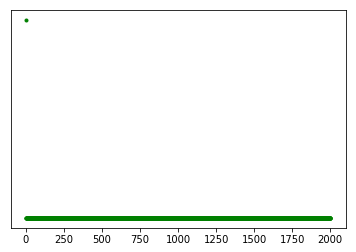

In [117]:
plt.plot(steps, errors ,'g.')
plt.yscale('log')

In [77]:
#resValues = pd.DataFrame(columns=['initial step', 'w', 'err'])

for initialStep in [0.0000001, 0.0000005, 0.000001, 0.00000005]:
    w = gradientDescent([0, 0, 0], data, initialStep, 0.1, 0, 1000000)
    print([initialStep, w, standardDeviation(w, data)])

[1e-07, [165.08184443623108, 0.2539113285855466, 0.08036674643037604], 69254.169991938004]
[5e-07, [165.35776910704715, 0.28895026610584323, 0.1003849590860165], 69251.15758811128]
[1e-06, [165.38930041534357, 0.34443378558903404, 0.13224429504688273], 69251.120543336947]
[5e-08, [162.61368149367797, 0.24871438288948833, 0.0783605688313167], 69506.510484302009]


In [120]:
from tqdm import tqdm

In [122]:
m = 100000
mw = [0, 0, 0]
for i in tqdm(range(0, 20000, 500)):
    w0 = [i, i, i]
    #w0 = [np.random.uniform(-1000,1000) for i in range(3)]
    w = gradientDescent(w0, data, 0.001, 0.1, 0, 1000000)
    sd = standardDeviation(w, data)
    print(sd, w0, w)
    if (sd < m):
        m = sd
        mw = w0
print(m, mw)


  0%|          | 0/40 [00:00<?, ?it/s]


KeyboardInterrupt: 

In [215]:
w = gradientDescent([0, 0, 0], ndata, 0.6, 0, 0, 10000)
resValues = pd.DataFrame(columns=['area', 'rooms', 'price', 'predict'])
for area, rooms in data:
    cur = pd.DataFrame([[area, rooms, actualPrice[(area, rooms)], predictPrice(area, rooms, w)]], 
                       columns=['area', 'rooms', 'price', 'predict'])
    resValues = resValues.append(cur, ignore_index=True)

print('weights:', w)
print('deviation', standardDeviation(w, ndata))

# display(resValues)

weights: [504777.9039879095, -34952.076449310654, 199467.38469348647]
deviation 63926.2082499


In [214]:
printResults2(w, data)

[(2104, 3), (1600, 3), (2400, 3), (1416, 2), (3000, 4), (1985, 4), (1534, 3), (1427, 3), (1380, 3), (1494, 3), (1940, 4), (2000, 3), (1890, 3), (4478, 5), (1268, 3), (2300, 4), (1320, 2), (1236, 3), (2609, 4), (3031, 4), (1767, 3), (1888, 2), (1604, 3), (1962, 4), (3890, 3), (1100, 3), (1458, 3), (2526, 3), (2200, 3), (2637, 3), (1839, 2), (1000, 1), (2040, 4), (3137, 3), (1811, 4), (1437, 3), (1239, 3), (2132, 4), (4215, 4), (2162, 4), (1664, 2), (2238, 3), (2567, 4), (1200, 3), (852, 2), (1852, 4), (1203, 3)]


TypeError: unsupported operand type(s) for -: 'int' and 'list'

In [73]:
standardDeviation([0, 0, 0], data)

362192.07088631147

In [216]:
def differential_evolution(trainingData, crossover_probability=0.8):
    F = 0.7
    def generate_vector():
        return [np.random.uniform(-1000000,1000000) for i in range(3)]
    
    population = [generate_vector() for i in range(20)]
    
    for i in range(10000):
        for j in range(len(population)):
            old_entity = population[j]
            ind = list()
            while len(ind) < 3:
                temp = int(np.random.uniform(0, len(population)))
                if temp != j:
                    ind.append(temp)
            ind = [population[k] for k in ind]
            new_entity = [ind[0][k] + F * (ind[1][k] - ind[2][k]) for k in range(3)]
            
            for k in range(3):
                if np.random.uniform(0, 1) > crossover_probability:
                    new_entity[k] = old_entity[k]
            if standardDeviation(new_entity, trainingData) < standardDeviation(old_entity, trainingData):
                population[j] = new_entity
           
    deviation = -1
    result = None
    for ent in population:
        current = standardDeviation(ent, trainingData)
        if deviation == -1 or deviation > current:
            deviation = current
            result    = ent
    return result, deviation

w_evolution, accuracy = differential_evolution(ndata)
print('weights:', w_evolution, 'deviation', accuracy)

weights: [504777.9042485998, -34952.07266575688, 199467.3825572089] deviation 63926.2082499


In [211]:
printResults2(w, data)

[(2104, 3), (1600, 3), (2400, 3), (1416, 2), (3000, 4), (1985, 4), (1534, 3), (1427, 3), (1380, 3), (1494, 3), (1940, 4), (2000, 3), (1890, 3), (4478, 5), (1268, 3), (2300, 4), (1320, 2), (1236, 3), (2609, 4), (3031, 4), (1767, 3), (1888, 2), (1604, 3), (1962, 4), (3890, 3), (1100, 3), (1458, 3), (2526, 3), (2200, 3), (2637, 3), (1839, 2), (1000, 1), (2040, 4), (3137, 3), (1811, 4), (1437, 3), (1239, 3), (2132, 4), (4215, 4), (2162, 4), (1664, 2), (2238, 3), (2567, 4), (1200, 3), (852, 2), (1852, 4), (1203, 3)]


TypeError: unsupported operand type(s) for -: 'int' and 'list'

In [62]:
extra_points = [(100, 1)]

for area, rooms in extra_points:
    print('area: ', area, ' rooms: ', rooms)
    print('gradient: ', predictPrice(area, rooms, w))
    print('genetics: ', predictPrice(area, rooms, w_evolution))

area:  100  rooms:  1
gradient:  44601.6109425326
genetics:  94780.9578454603
